## A Notebook to Forecast the Next Two Days of Power Generation

In [45]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

#p1_url = 'https://github.com/LucMaingard/solar-plant/blob/main/data/raw/Plant_1_Generation_Data.csv?raw=true'
#p2_url = 'https://github.com/LucMaingard/solar-plant/blob/main/data/raw/Plant_2_Generation_Data.csv?raw=true'
#w1_url = 'https://github.com/LucMaingard/solar-plant/blob/main/data/raw/Plant_1_Weather_Sensor_Data.csv?raw=true'
#w2_url = 'https://github.com/LucMaingard/solar-plant/blob/main/data/raw/Plant_2_Weather_Sensor_Data.csv?raw=true'
p1_url = '/Users/lucmaingard/Dropbox/work/projects/solar/data/raw/Plant_1_Generation_Data.csv'
p2_url = '/Users/lucmaingard/Dropbox/work/projects/solar/data/raw/Plant_2_Generation_Data.csv'
w1_url = '/Users/lucmaingard/Dropbox/work/projects/solar/data/raw/Plant_1_Weather_Sensor_Data.csv'
w2_url = '/Users/lucmaingard/Dropbox/work/projects/solar/data/raw/Plant_2_Weather_Sensor_Data.csv'

# plant datasets
df_p1 = pd.read_csv(p1_url)
df_p2 = pd.read_csv(p2_url)

# weather datasets
df_w1 = pd.read_csv(w1_url)
df_w2 = pd.read_csv(w2_url)

In [3]:
df_p1.head()

,DATE_TIME,PLANT_ID,SOURCE_KEY,DC_POWER,AC_POWER,DAILY_YIELD,TOTAL_YIELD
0,15-05-2020 00:00,4135001,1BY6WEcLGh8j5v7,0.0,0.0,0.0,6259559.0
1,15-05-2020 00:00,4135001,1IF53ai7Xc0U56Y,0.0,0.0,0.0,6183645.0
2,15-05-2020 00:00,4135001,3PZuoBAID5Wc2HD,0.0,0.0,0.0,6987759.0
3,15-05-2020 00:00,4135001,7JYdWkrLSPkdwr4,0.0,0.0,0.0,7602960.0
4,15-05-2020 00:00,4135001,McdE0feGgRqW7Ca,0.0,0.0,0.0,7158964.0


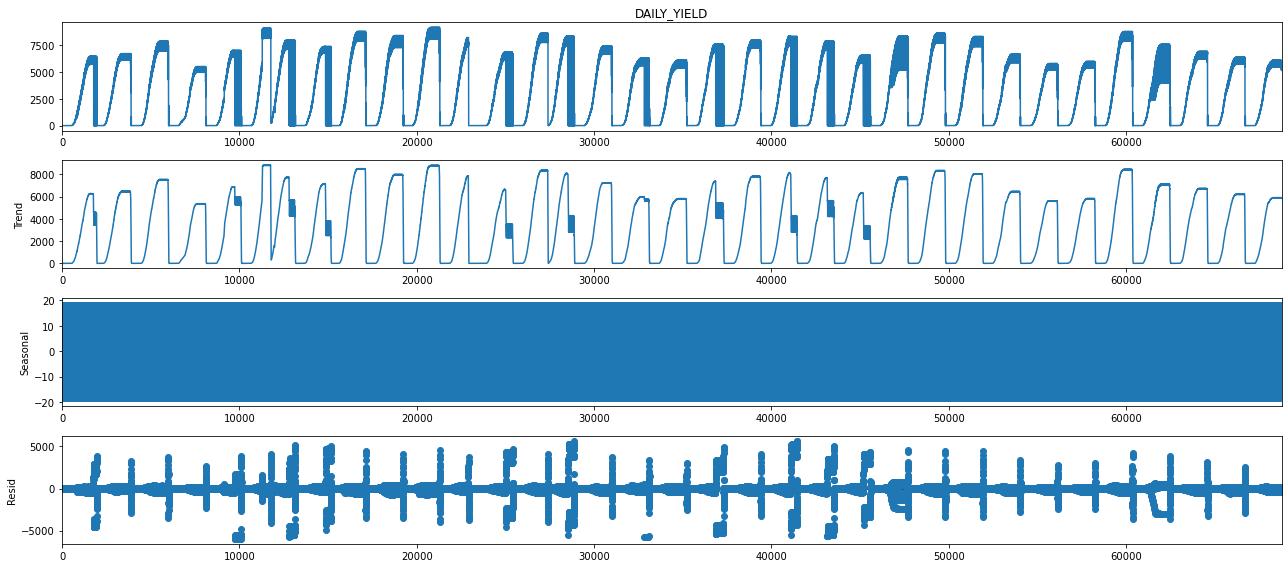

In [4]:
import statsmodels.api as sm
from pylab import rcParams
rcParams['figure.figsize'] = 18, 8
decomposition = sm.tsa.seasonal_decompose(df_p1.DAILY_YIELD, model='additive', period = 30)
fig = decomposition.plot()
plt.show()

In [5]:
from pandas.tseries.offsets import DateOffset
from pmdarima.arima import auto_arima
from statsmodels.tsa.stattools import adfuller

In [6]:
#collect data 
x_p1=df_p1.copy()
x_p1=x_p1.groupby('DATE_TIME').sum()
#x_p1['DAILY_YIELD'][-288:]

In [11]:
#Orangizing data for forecasting
pred_p1=df_p1.copy()
pred_p1=pred_p1.groupby('DATE_TIME').sum()
pred_p1=pred_p1['DAILY_YIELD'][-1579:].reset_index()
pred_p1.set_index('DATE_TIME',inplace=True)
pred_p1.head()

,DAILY_YIELD
DATE_TIME,
16-05-2020 13:30,99005.142857
16-05-2020 13:45,103092.767857
16-05-2020 14:00,106775.339286
16-05-2020 14:15,110655.267857
16-05-2020 14:30,115194.250002


In [12]:
result = adfuller(pred_p1['DAILY_YIELD'])
print('Augmented Dickey-Fuller Test:')

labels = ['ADF Test Statistic','p-value','#Lags Used','Number of Observations Used']

for value,label in zip(result,labels):
    print(label +' : '+str(value))

if result[1] <= 0.05:
    print("strong evidence against the null hypothesis, reject the null hypothesis. Data has no unit root and is stationary")
else:
    print("weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary ")

Augmented Dickey-Fuller Test:
ADF Test Statistic : -8.785975997203801
p-value : 2.3081435564987243e-14
#Lags Used : 23
Number of Observations Used : 1555
strong evidence against the null hypothesis, reject the null hypothesis. Data has no unit root and is stationary


In [13]:
pred_p1.shape

(1579, 1)

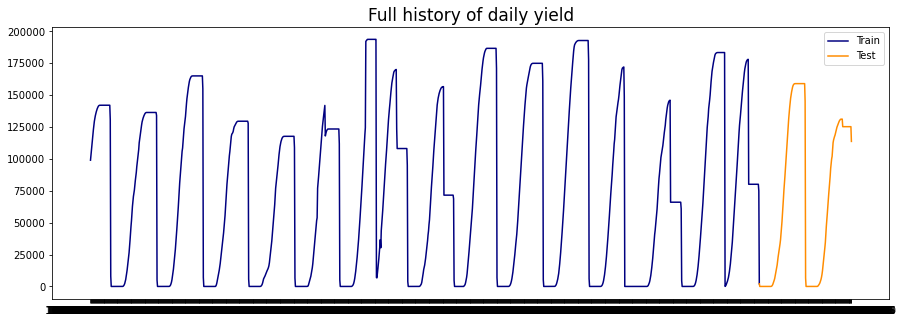

In [15]:
train=pred_p1[:1388]
test=pred_p1[-192:]
plt.figure(figsize=(15,5))
plt.plot(train,label='Train',color='navy')
plt.plot(test,label='Test',color='darkorange')
plt.title('Full history of daily yield',fontsize=17)
plt.legend()
plt.show()

In [16]:
arima_model = auto_arima(train,
                         start_p=0,d=1,start_q=0,
                         max_p=4,max_d=4,max_q=4,
                         start_P=0,D=1,start_Q=0,
                         max_P=1,max_D=1,max_Q=1,m=96,
                         seasonal=True,
                         error_action='warn',trace=True,
                         supress_warning=True,stepwise=True,
                         random_state=20,n_fits=1,
                         stationary=True)

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,0,0)[96] intercept   : AIC=34809.018, Time=0.03 sec
 ARIMA(1,0,0)(1,0,0)[96] intercept   : AIC=30567.089, Time=87.85 sec
 ARIMA(0,0,1)(0,0,1)[96] intercept   : AIC=inf, Time=60.31 sec
 ARIMA(0,0,0)(0,0,0)[96]             : AIC=35920.710, Time=0.04 sec
 ARIMA(1,0,0)(0,0,0)[96] intercept   : AIC=30690.043, Time=0.02 sec
 ARIMA(1,0,0)(1,0,1)[96] intercept   : AIC=30568.251, Time=126.83 sec
 ARIMA(1,0,0)(0,0,1)[96] intercept   : AIC=30585.515, Time=74.22 sec
 ARIMA(0,0,0)(1,0,0)[96] intercept   : AIC=34584.258, Time=45.99 sec
 ARIMA(2,0,0)(1,0,0)[96] intercept   : AIC=30558.372, Time=119.70 sec
 ARIMA(2,0,0)(0,0,0)[96] intercept   : AIC=30667.277, Time=0.08 sec
 ARIMA(2,0,0)(1,0,1)[96] intercept   : AIC=30559.809, Time=683.56 sec
 ARIMA(2,0,0)(0,0,1)[96] intercept   : AIC=30573.840, Time=95.32 sec
 ARIMA(3,0,0)(1,0,0)[96] intercept   : AIC=30560.181, Time=147.09 sec
 ARIMA(2,0,1)(1,0,0)[96] intercept   : AIC=30560.482, Time=202.86 

In [39]:
from datetime import datetime
datetime.strptime(test.index[-1], '%d-%m-%Y %H:%M') 

datetime.datetime(2020, 5, 31, 23, 45)

In [35]:
test.index[-1]

'31-05-2020 23:45'

In [27]:
DateOffset(minutes=5)

<DateOffset: minutes=5>

In [25]:
[DateOffset(minutes=5) for x in range(0,2910,15)]

[<DateOffset: minutes=0>,
 <DateOffset: minutes=15>,
 <DateOffset: minutes=30>,
 <DateOffset: minutes=45>,
 <DateOffset: minutes=60>,
 <DateOffset: minutes=75>,
 <DateOffset: minutes=90>,
 <DateOffset: minutes=105>,
 <DateOffset: minutes=120>,
 <DateOffset: minutes=135>,
 <DateOffset: minutes=150>,
 <DateOffset: minutes=165>,
 <DateOffset: minutes=180>,
 <DateOffset: minutes=195>,
 <DateOffset: minutes=210>,
 <DateOffset: minutes=225>,
 <DateOffset: minutes=240>,
 <DateOffset: minutes=255>,
 <DateOffset: minutes=270>,
 <DateOffset: minutes=285>,
 <DateOffset: minutes=300>,
 <DateOffset: minutes=315>,
 <DateOffset: minutes=330>,
 <DateOffset: minutes=345>,
 <DateOffset: minutes=360>,
 <DateOffset: minutes=375>,
 <DateOffset: minutes=390>,
 <DateOffset: minutes=405>,
 <DateOffset: minutes=420>,
 <DateOffset: minutes=435>,
 <DateOffset: minutes=450>,
 <DateOffset: minutes=465>,
 <DateOffset: minutes=480>,
 <DateOffset: minutes=495>,
 <DateOffset: minutes=510>,
 <DateOffset: minutes=525>,


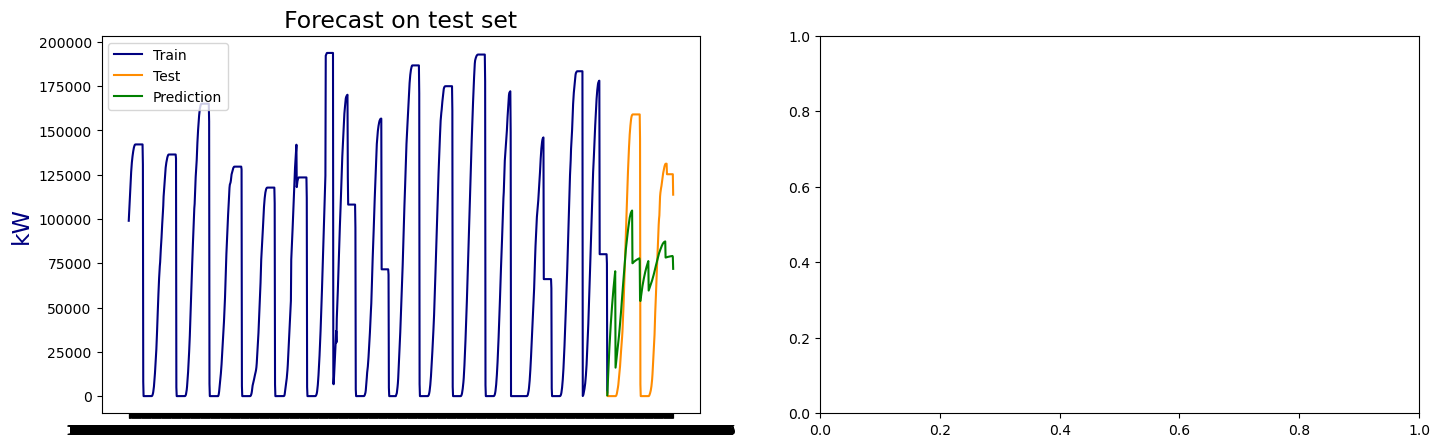

In [42]:
future_dates = [datetime.strptime(test.index[-1], '%d-%m-%Y %H:%M') + DateOffset(minutes=x) for x in range(0,2910,15) ]

prediction=pd.DataFrame(arima_model.predict(n_periods=192),index=test.index)
prediction.columns=['predicted_yield']

fig,ax= plt.subplots(ncols=2,nrows=1,dpi=100,figsize=(17,5))
ax[0].plot(train,label='Train',color='navy')
ax[0].plot(test,label='Test',color='darkorange')
ax[0].plot(prediction,label='Prediction',color='green')
ax[0].legend()
ax[0].set_title('Forecast on test set',size=17)
ax[0].set_ylabel('kW',color='navy',fontsize=17)


'''f_prediction=pd.DataFrame(arima_model.predict(n_periods=194),index=future_dates)
f_prediction.columns=['predicted_yield']
ax[1].plot(pred_p1,label='Original data',color='navy')
ax[1].plot(f_prediction,label='18th & 19th June',color='green')
ax[1].legend()
ax[1].set_title('Next days forecast',size=17)'''
plt.show()

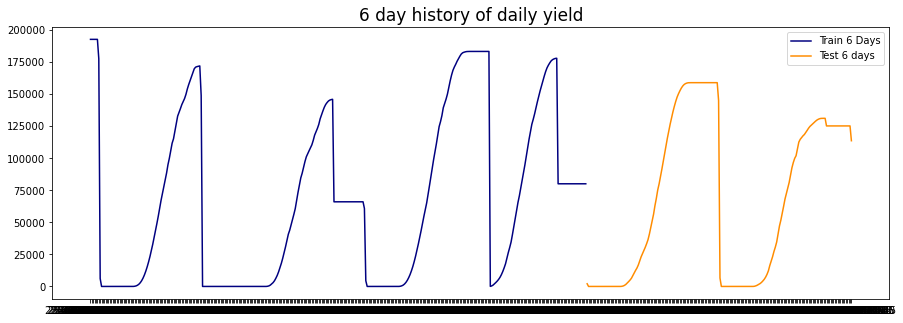

In [22]:
train_6days=pred_p1[-552:-193]
test_6day=pred_p1[-192:]
plt.figure(figsize=(15,5))
plt.plot(train_6days,label='Train 6 Days',color='navy')
plt.plot(test_6day,label='Test 6 days',color='darkorange')
plt.title('6 day history of daily yield',fontsize=17)
plt.legend()
plt.show()

In [43]:
arima_model_6days = auto_arima(train_6days,
                         start_p=0,d=1,start_q=0,
                         max_p=4,max_d=4,max_q=4,
                         start_P=0,D=1,start_Q=0,
                         max_P=1,max_D=1,max_Q=1,m=96,
                         seasonal=True,
                         error_action='warn',trace=True,
                         supress_warning=True,stepwise=True,
                         random_state=20,n_fits=1,
                         stationary=True)

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,0,0)[96] intercept   : AIC=8994.077, Time=0.05 sec


KeyboardInterrupt: 

ModuleNotFoundError: No module named 'tensorflow'